In [1]:
# data wrangling and linear algebra
import pandas as pd
import numpy as np
import pandas_ta as ta

# data visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import matplotlib

# metrics
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

# yahoo finance api
import yfinance as yf

# statistical tests
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

# framework
import tensorflow as tf
from tensorflow.keras import layers, models

# misc
import warnings
import os


warnings.filterwarnings(action='ignore')
pd.set_option('display.max_rows',500)
matplotlib.rcParams['figure.figsize']  = (12,8)

In [2]:
# get microsoft stock data
msft = yf.Ticker('MSFT')

# get stock info
msft.info

{'zip': '98052-6399',
 'sector': 'Technology',
 'fullTimeEmployees': 163000,
 'longBusinessSummary': 'Microsoft Corporation develops, licenses, and supports software, services, devices, and solutions worldwide. Its Productivity and Business Processes segment offers Office, Exchange, SharePoint, Microsoft Teams, Office 365 Security and Compliance, and Skype for Business, as well as related Client Access Licenses (CAL); Skype, Outlook.com, and OneDrive; LinkedIn that includes Talent, Learning, Sales, and Marketing solutions, as well as premium subscriptions; and Dynamics 365, a set of cloud-based and on-premises business solutions for small and medium businesses, large organizations, and divisions of enterprises. Its Intelligent Cloud segment licenses SQL and Windows Servers, Visual Studio, System Center, and related CALs; GitHub that provides a collaboration platform and code hosting service for developers; and Azure, a cloud platform. It also offers support services and Microsoft consu

In [110]:
# get historical market data
hist = msft.history(start = '2005-07-01', end = '2020-07-31', period = '1d')
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2005-06-30,18.20,18.25,18.02,18.04,82018200,0.0,0
2005-07-01,18.04,18.14,17.91,17.94,69718400,0.0,0
2005-07-05,17.90,18.29,17.88,18.14,61883500,0.0,0
2005-07-06,18.13,18.21,17.93,17.93,64214600,0.0,0
2005-07-07,17.85,17.94,17.79,17.90,80082900,0.0,0
...,...,...,...,...,...,...,...
2020-07-24,200.42,202.86,197.51,201.30,39827000,0.0,0
2020-07-27,201.47,203.97,200.86,203.85,30160900,0.0,0
2020-07-28,203.61,204.70,201.74,202.02,23251400,0.0,0


In [111]:
# droppping stock splits and dividends
hist.drop(['Dividends', 'Stock Splits'], axis = 1, inplace=True)

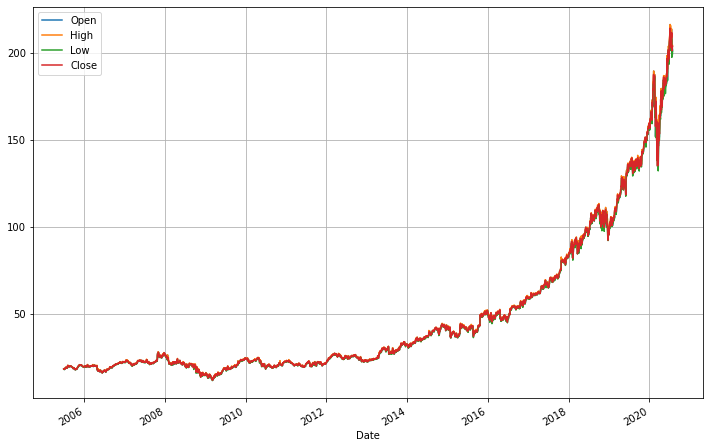

In [112]:
hist.drop('Volume', axis = 1).plot(grid = True)
plt.show()

In [113]:
def get_features(df):  
    """
    Calculates technical indicators:
    20 SMA, 20 EMA, RSI, MACD, CCI, BOLLINDER BANDA
    """
    df.columns =  ['open', 'high', 'low', 'close', 'volume']
    df.ta.sma(20, append = True)
    df.ta.ema(20, append = True)
    df.ta.rsi(length = 20, append = True)
    df.ta.macd(append = True)
    df.ta.cci(append = True)
    df.ta.bbands(append = True)
    
    return df.dropna()
    

In [114]:
hist = get_features(hist)
hist.head()

,open,high,low,volume,close,SMA_10,EMA_10,RSI_20,MACD_12_26_9,MACDH_12_26_9,MACDS_12_26_9,CCI_14_0.015,BBL_5,BBM_5,BBU_5
Date,,,,,,,,,,,,,,,
2005-08-08,20.18,20.21,19.66,77207200,19.70,19.228,19.402979,55.583151,0.511987,-0.001313,0.513299,110.198055,19.292120,19.792,20.291880
2005-08-09,19.76,19.97,19.61,64761800,19.86,19.360,19.486074,57.370772,0.517630,0.003465,0.514166,85.614764,19.523013,19.870,20.216987
2005-08-10,19.90,19.97,19.49,62818800,19.57,19.450,19.501333,53.289141,0.493019,-0.016917,0.509936,58.017360,19.385183,19.826,20.266817
2005-08-11,19.59,19.82,19.52,48646800,19.80,19.560,19.555636,55.901802,0.486466,-0.018776,0.505242,54.401220,19.377001,19.818,20.258999
2005-08-12,19.66,19.71,19.53,52006500,19.64,19.665,19.570975,53.707572,0.463024,-0.033774,0.496799,36.711369,19.479224,19.714,19.948776


In [115]:
def split_data(df, split_time):
    """
    Split data on the basis of date provided
    """
    
    split_index = len(hist.loc[hist.index < split_time])
    train_data = hist.iloc[:split_index]
    val_data = hist.iloc[split_index:]
    
    print('Total training points: ', train_data.shape[0])
    print('Total validation points: ', val_data.shape[0])
    
    return split_index, train_data, val_data

split_index, train_data, val_data = split_data(hist, '2019-01-01')

Total training points:  3373
Total validation points:  398


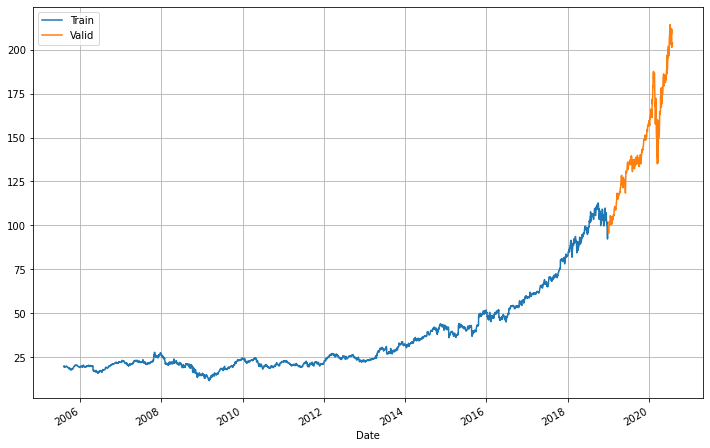

In [116]:
pd.concat([train_data['close'], val_data['close']], axis = 1).plot(grid = True)
plt.legend(['Train', 'Valid'])
plt.show()

In [117]:
def normalise_window_data(data, window_size = 50):
    data = data.copy()
    norm_data = []
    
    for time in range(len(data)-window_size):
        window_data = data.iloc[time:time+window_size,:]
        normalised_window = []
        for col in range(data.shape[1]):
            norm_col = ((window_data.iloc[:,col]/window_data.iloc[0,col])-1).values
            normalised_window.append(norm_col)
        normalised_window = np.array(normalised_window).T
        norm_data.append(normalised_window)
    
    norm_data = np.array(norm_data)    
    return norm_data

In [118]:
def create_dataset(series, window_size, batch_size, shuffle_buffer = 1000):
    
    """
    Creates windowed dataset, data from time step t:t+window_size is input X and the next value is output y
    
    :params series: the series for which dataset to be created (numpy array)
    :params window_size: window size of each input X
    :params batch_size: batch size for training
    :params shuffle_buffer: buffer parameter for shuffling the data in tf shuffle API
    
    returns generator object to generate input X, output y (arrays)
    """
    train_norm = normalise_window_data(train_data, window_size = window_size)
    
    dataset = tf.data.Dataset.from_tensor_slices(train_norm)    
    dataset = dataset.map(lambda w: (w[:-1,:], w[-1,3]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset


In [119]:
# params
window_size = 60
batch_size = 100
epochs = 100
shuffle_buffer = 1000

In [120]:
train_dataset = create_dataset(train_data, window_size, batch_size)

In [128]:
tf.keras.backend.clear_session()
# model architecture

# create model
model = models.Sequential([
    layers.LSTM(100, input_shape = [None, train_data.shape[-1]], return_sequences = True),
    layers.Dropout(0.5),    
    layers.LSTM(100, return_sequences = True),
    layers.Dropout(0.3),
    layers.LSTM(100, return_sequences = False),
    layers.Dropout(0.2),
 #   layers.Dense(50, activation = 'relu'),       
    layers.Dense(1, activation = 'relu')    
])

#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps = 100000, decay_rate = 0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)


model.compile(loss = 'mse', optimizer = optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 100)         46400     
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 100)         80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [129]:
history = model.fit(train_dataset, epochs = epochs)

Epoch 1/100
34/34 [==============================] - 1s 23ms/step - loss: 0.0063: 0s - loss: 0
Epoch 2/100
34/34 [==============================] - 1s 23ms/step - loss: 0.0059
Epoch 3/100
34/34 [==============================] - 1s 22ms/step - loss: 0.0056
Epoch 4/100
34/34 [==============================] - 1s 34ms/step - loss: 0.0047
Epoch 5/100
34/34 [==============================] - 1s 22ms/step - loss: 0.0042
Epoch 6/100
34/34 [==============================] - 1s 28ms/step - loss: 0.0040
Epoch 7/100
34/34 [==============================] - 1s 30ms/step - loss: 0.0037
Epoch 8/100
34/34 [==============================] - 1s 28ms/step - loss: 0.0036
Epoch 9/100
34/34 [==============================] - 1s 28ms/step - loss: 0.0034
Epoch 10/100
34/34 [==============================] - 1s 30ms/step - loss: 0.0033
Epoch 11/100
34/34 [==============================] - 1s 23ms/step - loss: 0.0033
Epoch 12/100
34/34 [==============================] - 1s 28ms/step - loss: 0.0032
Epoch 13/10

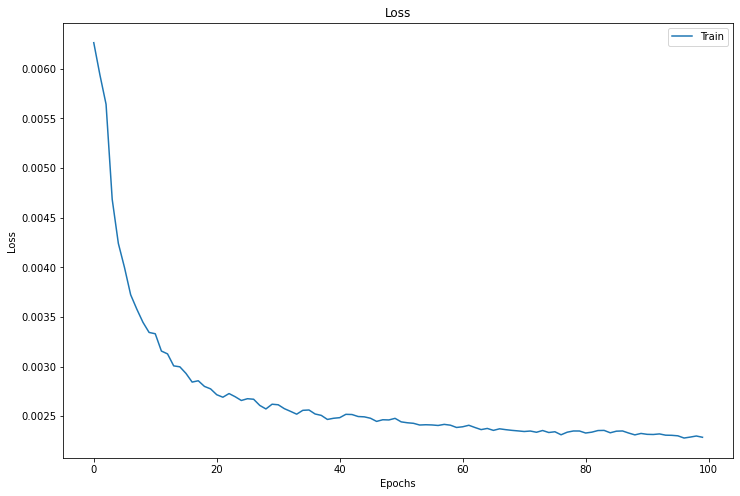

In [130]:
# plotting
plt.plot(history.history['loss'], label = 'Train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Code courtesy: https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction/blob/master/core/data_processor.py

In [131]:
def get_test_data(data, window):
    """
    Returns the test data in model input format
    """
    
    data_windows = []
    for time in range(len(data) - window):
        window_data = data.values[time:time+window]
        normalised_window = []
        for col in range(data.shape[1]):
            norm_col = [((float(p)/float(window_data[0,col]))-1) for p in window_data[:,col]]
            normalised_window.append(norm_col)
        
        normalised_window = np.array(normalised_window).T
        data_windows.append(normalised_window)
            
    data_windows = np.array(data_windows).astype(float)
    
    x = data_windows[:,:-1]
    y = data_windows[:,-1,3]
    
    return x,y

In [132]:
x_test, y_test = get_test_data(val_data, window_size)

In [133]:
def get_multi_sequence_forecast(model, x_test, window_size, prediction_len = window_size):
    """
    Predicts for the prediction len steps for each window of the test data. Then resets and shifts to the next window.
    """
    
    prediction_seq = []
    for i in range(round(len(x_test)/prediction_len)):
        curr_frame = x_test[i*prediction_len]
        
        predictions = []
        for j in range(prediction_len):
            predictions.append(model.predict(curr_frame[np.newaxis,:,:]))
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, window_size-2, predictions[-1], axis = 0)
            
        prediction_seq.append(predictions)
        
    return prediction_seq  
forecast = get_multi_sequence_forecast(model, x_test, window_size)

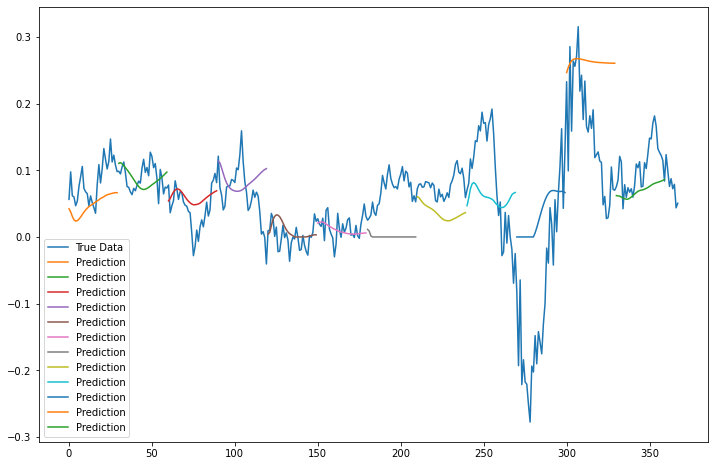

In [134]:
def plot_results_multiple(predicted_data, true_data, prediction_len = window_size):
    """
    Plots the results of predicted windows
    """
    
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plot_data = np.array(padding+data).flatten()
        plt.plot(plot_data, label='Prediction')
        plt.legend()
    plt.show()
plot_results_multiple(forecast, y_test)